# Prediction of Video Memorability using Ensemble Technique

In [206]:
import pandas as pd
import tensorflow
import numpy as np
import matplotlib.pyplot as plt
import os
import pyprind
import sklearn.svm

from string import punctuation
from collections import Counter

from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import BayesianRidge
from sklearn.tree import DecisionTreeRegressor

from tensorflow.python.keras import Sequential
from tensorflow.python.keras import layers
from tensorflow.python.keras import regularizers
from tensorflow.python.keras.preprocessing.text import Tokenizer

from numpy.random import seed
seed(1)

#### Mounting the Drive to access dataset:

## Function for calculating Spearman's Correlation Co-efficient to be used for the evaluation of predicted values:

In [2]:
def Get_score(Y_pred,Y_true):
    '''Calculate the Spearmann"s correlation coefficient'''
    Y_pred = np.squeeze(Y_pred)
    Y_true = np.squeeze(Y_true)
    if Y_pred.shape != Y_true.shape:
        print('Input shapes don\'t match!')
    else:
        if len(Y_pred.shape) == 1:
            Res = pd.DataFrame({'Y_true':Y_true,'Y_pred':Y_pred})
            score_mat = Res[['Y_true','Y_pred']].corr(method='spearman',min_periods=1)
            print('The Spearman\'s correlation coefficient is: %.3f' % score_mat.iloc[1][0])
        else:
            for ii in range(Y_pred.shape[1]):
                Get_score(Y_pred[:,ii],Y_true[:,ii])

## Loading video & image features and ground truth from Dev-set:

> Video features, C3D & HMP and image feature, Inception-V3 are selected.

### Loading C3D values:

In [3]:
def read_C3D(dirname):
    """Scan vectors from file"""
    vn = []
    c3d = []
    df = pd.DataFrame()
    for filename in os.listdir(dirname):
        if filename.endswith(".txt"):
            f=filename.replace('.txt','')
        else:
            continue
        with open (os.path.join(dirname,filename)) as full_path:
            for line in full_path:
                C3D =[float(item) for item in line.split()] # convert to float type, using default separator
        vn.append(f)
        c3d.append(C3D)
    
    df['video']=vn
    df['C3D']=c3d
    return df

In [4]:
directory_C3D = r'C:\Users\Administrator\Downloads\CA684 ML\C3D'
df_c3d=read_C3D(directory_C3D)

In [5]:
df_c3d.head()

,video,C3D
0,video10,"[9.006e-05, 0.00061494, 0.00343634, 0.00128092..."
1,video100,"[0.00231174, 0.00996551, 0.02743902, 5.85e-06,..."
2,video1001,"[0.46803489, 0.4895013, 7.944e-05, 9.68e-06, 2..."
3,video1003,"[0.01403566, 0.00049223, 0.00023311, 2.793e-05..."
4,video1004,"[0.04673432, 0.00086782, 5.25e-06, 8.05e-06, 2..."


### Loading HMP values:

In [9]:
def read_HMP(dirname):
    """Scan HMP(Histogram of Motion Patterns) features from file"""
    vn = []
    hmp = []
    HMPList = []
    df = pd.DataFrame()
    for filename in os.listdir(dirname):
        if filename.endswith(".txt"):
            f=filename.replace('.txt','')
        else:
            continue
        with open (os.path.join(dirname,filename)) as full_path:
            for line in full_path:
                pairs=line.split()
                HMP_temp = { int(p.split(':')[0]) : float(p.split(':')[1]) for p in pairs}
        HMP = np.zeros(6075)
        for idx in HMP_temp.keys():
            HMP[idx-1] = HMP_temp[idx]
        HMPList = HMP.tolist()
        vn.append(f)
        hmp.append(HMPList)
    
    df['video']=vn
    df['HMP']=hmp
    return df

In [10]:
directory_HMP = r'C:\Users\Administrator\Downloads\CA684 ML\HMP'
df_hmp=read_HMP(directory_HMP)

In [11]:
df_hmp.shape
df_hmp.head()

,video,HMP
0,video10,"[0.005026, 0.001356, 5.5e-05, 0.0, 0.000665, 2..."
1,video100,"[0.019473, 0.005004, 9.8e-05, 0.0, 0.001991, 3..."
2,video1001,"[0.00725, 0.002722, 5e-05, 0.0, 0.00107, 5.5e-..."
3,video1003,"[0.071224, 0.011862, 0.00032, 0.0, 0.00718, 0...."
4,video1004,"[0.053318, 0.009491, 0.000454, 0.0, 0.004754, ..."


### Loading Inception-V3 values:

In [13]:
def read_InceptionV3(fname):
    with open(fname,'r') as f:
         for line in f:
            pairs=line.split()
            IV3_temp = { int(p.split(':')[0]) : float(p.split(':')[1]) for p in pairs}
    IV3 = np.zeros(1000)
    for idx in IV3_temp.keys():
        IV3[idx-1] = IV3_temp[idx]
    IV3List = IV3.tolist()
    return(IV3List)

df_I0 = pd.DataFrame()
df_I56 = pd.DataFrame()
df_I112 = pd.DataFrame()
vn0 = []
vn56 = []
vn112 = []
I0 = []
I56 = []
I112 = []

directory_IncepV3 = r'C:\Users\Administrator\Downloads\CA684 ML\InceptionV3'
for filename in os.listdir(directory_IncepV3):
    if filename.endswith("-0.txt"):
        f=filename.replace('-0.txt','')
        ff = os.path.join(directory_IncepV3, filename)
        vn0.append(f)
        I0.append(read_InceptionV3(ff))
    if filename.endswith("-56.txt"):
        f=filename.replace('-56.txt','')
        ff = os.path.join(directory_IncepV3, filename)
        vn56.append(f)
        I56.append(read_InceptionV3(ff))
    if filename.endswith("-112.txt"):
        f=filename.replace('-112.txt','')
        ff = os.path.join(directory_IncepV3, filename)
        vn112.append(f)
        I112.append(read_InceptionV3(ff))
        
df_I0['video'] = vn0
df_I0['I0'] = I0
df_I56['video'] = vn56
df_I56['I56'] = I56
df_I112['video'] = vn112
df_I112['I112'] = I112

In [14]:
df_iv3 = df_I0.merge(df_I56,on='video').merge(df_I112,on='video')

In [15]:
df_iv3.shape
type(df_iv3)

pandas.core.frame.DataFrame

### Loading ground truth values:

In [16]:
grd_truth = pd.read_csv(r'C:\Users\Administrator\Downloads\CA684 ML\Ground-truth\ground-truth.csv')

In [17]:
grd_truth.head()

,video,short-term_memorability,nb_short-term_annotations,long-term_memorability,nb_long-term_annotations
0,video3.webm,0.924,34,0.846,13
1,video4.webm,0.923,33,0.667,12
2,video6.webm,0.863,33,0.700,10
3,video8.webm,0.922,33,0.818,11
4,video10.webm,0.950,34,0.900,10


In [18]:
grd_truth.describe()

,short-term_memorability,nb_short-term_annotations,long-term_memorability,nb_long-term_annotations
count,6000.000000,6000.000000,6000.000000,6000.000000
mean,0.860243,36.291500,0.778942,12.764667
std,0.080655,8.356285,0.144692,3.544815
min,0.388000,30.000000,0.000000,9.000000
25%,0.811000,33.000000,0.700000,10.000000
50%,0.867000,34.000000,0.800000,12.000000
75%,0.923000,34.000000,0.900000,14.000000
max,0.989000,100.000000,1.000000,40.000000


## Data Preparation:

### Removing '.webm' from the video names of ground-truth.csv file:

In [19]:
grd_truth['video']=grd_truth['video'].str.replace('.webm', '')
grd_truth=grd_truth.drop(['nb_short-term_annotations','nb_long-term_annotations'],axis=1)
grd_truth.head()

,video,short-term_memorability,long-term_memorability
0,video3,0.924,0.846
1,video4,0.923,0.667
2,video6,0.863,0.700
3,video8,0.922,0.818
4,video10,0.950,0.900


### Combining C3D, HMP, and Inception-V3 values and ground-truth values into single dataframe:

In [20]:
final_pd = df_c3d.merge(df_hmp, on='video', how='inner').merge(df_iv3,on='video',how='inner').merge(grd_truth, on='video', how='inner')
final_pd.head()

,video,C3D,HMP,I0,I56,I112,short-term_memorability,long-term_memorability
0,video10,"[9.006e-05, 0.00061494, 0.00343634, 0.00128092...","[0.005026, 0.001356, 5.5e-05, 0.0, 0.000665, 2...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 2.811053e-...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 3.663038e-...","[9.209152e-35, 0.0, 0.0, 0.0, 2.733693e-31, 3....",0.950,0.900
1,video100,"[0.00231174, 0.00996551, 0.02743902, 5.85e-06,...","[0.019473, 0.005004, 9.8e-05, 0.0, 0.001991, 3...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 5.883199e-...",0.951,0.889
2,video1001,"[0.46803489, 0.4895013, 7.944e-05, 9.68e-06, 2...","[0.00725, 0.002722, 5e-05, 0.0, 0.00107, 5.5e-...","[0.0, 0.0, 0.0, 0.0, 6.735891e-33, 0.0, 0.0, 3...","[0.0, 0.0, 0.0, 0.0, 9.812947e-38, 0.0, 0.0, 2...","[0.0, 0.0, 0.0, 0.0, 4.727338e-33, 0.0, 0.0, 1...",0.899,1.000
3,video1003,"[0.01403566, 0.00049223, 0.00023311, 2.793e-05...","[0.071224, 0.011862, 0.00032, 0.0, 0.00718, 0....","[1.035399e-33, 0.0, 0.0, 0.0, 4.48396e-35, 0.0...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0.867,0.846
4,video1004,"[0.04673432, 0.00086782, 5.25e-06, 8.05e-06, 2...","[0.053318, 0.009491, 0.000454, 0.0, 0.004754, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 2.384511e-...","[0.0, 0.0, 0.0, 0.0, 0.0, 4.027571e-35, 0.0, 7...","[1.869558e-35, 0.0, 0.0, 0.0, 1.195717e-34, 1....",0.753,0.571


## Model Implementation and Evaluation with individual C3D feature:

> C3D values from combined dataframe are split into train and validation set into 80:20 ratio.

> Spearman's correlation co-efficient is used for evaluating the predictions of validation-set (20%) from dev-set.

### Implementing Convolutional Neural Networks on C3D to predict scores for validation-set (20%) from dev-set:

In [166]:
x_c3d = np.array(final_pd['C3D'].tolist())
print(type(x_c3d))
print('x',x_c3d.shape)

y = final_pd[['short-term_memorability','long-term_memorability']].values

<class 'numpy.ndarray'>
x (6000, 101)


In [167]:
x_cnntrain_c3d, x_cnntest_c3d, y_train, y_test = train_test_split(x_c3d, y, test_size=0.2, random_state=42) # random state for reproducability
print('x_train', x_cnntrain_c3d.shape)
print('x_test', x_cnntest_c3d.shape)
print('y_train', y_train.shape)
print('y_test', y_test.shape)

x_train (4800, 101)
x_test (1200, 101)
y_train (4800, 2)
y_test (1200, 2)


In [168]:
max_len=101

In [169]:
cnn_model = Sequential()

cnn_model.add(layers.Dense(10,activation='relu',kernel_regularizer=regularizers.l2(0.0005),input_shape=(max_len,)))
cnn_model.add(layers.Dropout(0.5))
cnn_model.add(layers.Dense(10,activation='relu',kernel_regularizer=regularizers.l2(0.0005)))
cnn_model.add(layers.Dropout(0.5))
cnn_model.add(layers.Dense(2,activation='sigmoid'))

In [192]:
cnn_model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_15 (Dense)             (None, 10)                61770     
_________________________________________________________________
dropout_10 (Dropout)         (None, 10)                0         
_________________________________________________________________
dense_16 (Dense)             (None, 10)                110       
_________________________________________________________________
dropout_11 (Dropout)         (None, 10)                0         
_________________________________________________________________
dense_17 (Dense)             (None, 2)                 22        
Total params: 61,902
Trainable params: 61,902
Non-trainable params: 0
_________________________________________________________________


In [170]:
cnn_model.compile(optimizer='rmsprop',loss='mse',metrics=['accuracy'])

history = cnn_model.fit(x_cnntrain_c3d,y_train,epochs=20)

loss = history.history['loss']

epochs = range(1,len(loss)+1)

Epoch 1/20
150/150 [==============================] - 11s 6ms/step - loss: 0.1053 - accuracy: 0.6313
Epoch 2/20
150/150 [==============================] - 0s 3ms/step - loss: 0.0349 - accuracy: 0.6806
Epoch 3/20
150/150 [==============================] - 0s 3ms/step - loss: 0.0243 - accuracy: 0.6817
Epoch 4/20
150/150 [==============================] - 0s 3ms/step - loss: 0.0202 - accuracy: 0.6923
Epoch 5/20
150/150 [==============================] - 0s 3ms/step - loss: 0.0180 - accuracy: 0.7025
Epoch 6/20
150/150 [==============================] - 0s 3ms/step - loss: 0.0165 - accuracy: 0.7027
Epoch 7/20
150/150 [==============================] - 1s 3ms/step - loss: 0.0152 - accuracy: 0.6991
Epoch 8/20
150/150 [==============================] - 0s 2ms/step - loss: 0.0159 - accuracy: 0.7013
Epoch 9/20
150/150 [==============================] - 1s 4ms/step - loss: 0.0149 - accuracy: 0.7124
Epoch 10/20
150/150 [==============================] - 0s 3ms/step - loss: 0.0146 - accuracy: 0.705

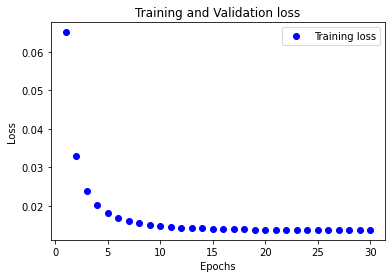

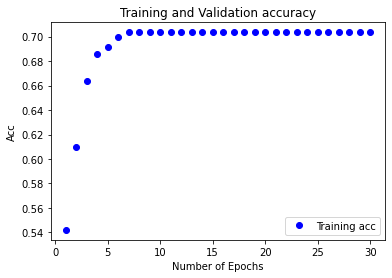

In [205]:
plt.plot(epochs,loss,'bo',label='Training loss')
plt.title('Training and Validation loss')
plt.xlabel('Number of Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

plt.figure()
acc = history.history['accuracy']
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.title('Training and Validation accuracy')
plt.xlabel('Number of Epochs')
plt.ylabel('Acc')
plt.legend()
plt.show()

In [172]:
predictions_cnnc3d = cnn_model.predict(x_cnntest_c3d)
print(predictions_cnnc3d.shape)
print(predictions_cnnc3d)

(1200, 2)
[[0.8576187  0.7762222 ]
 [0.85754025 0.7761472 ]
 [0.8579123  0.7765031 ]
 ...
 [0.8577283  0.77632695]
 [0.85780865 0.7764039 ]
 [0.8578601  0.77645314]]


In [173]:
Get_score(predictions_cnnc3d, y_test)

The Spearman's correlation coefficient is: 0.244
The Spearman's correlation coefficient is: 0.175


### Implementing Stacking Model on C3D to predict scores for validation-set (20%) from dev-set:

> Algorithms used: Decision Tree, Random Forest, and Bayesian Ridge.

In [28]:
X = np.array(final_pd['C3D'].tolist())

Y_ST=final_pd['short-term_memorability'].values
Y_LT=final_pd['long-term_memorability'].values

In [29]:
Xs_train, Xs_test, Ys_train, Ys_test = train_test_split(X, Y_ST, test_size=0.2, random_state=42)
Xl_train, Xl_test, Yl_train, Yl_test = train_test_split(X, Y_LT, test_size=0.2, random_state=42)
Xs_train.shape

(4800, 101)

In [30]:
Xl_train = pd.DataFrame(Xl_train)
Xs_train = pd.DataFrame(Xs_train)
Xl_test = pd.DataFrame(Xl_test)
Xs_test = pd.DataFrame(Xs_test)
Yl_train =pd.DataFrame(Yl_train)
Ys_train = pd.DataFrame(Ys_train)
Ys_test = pd.DataFrame(Ys_test)
Yl_test = pd.DataFrame(Yl_test)

In [204]:
def Stacking(model,train,y,test,n_fold):
   folds=KFold(n_splits=n_fold,random_state=42)
   test_pred=np.empty((0,1),float)
   train_pred=np.empty((0,1),float)
   for train_indices,val_indices in folds.split(train,y.values.ravel()):
      x_train,x_val=train.iloc[train_indices],train.iloc[val_indices]
      y_train,y_val=y.iloc[train_indices].values.ravel(),y.iloc[val_indices]
      model.fit(X=x_train,y=y_train)
      train_pred=np.append(train_pred,model.predict(x_val))
   test_pred=np.append(test_pred,model.predict(test))
   return test_pred.reshape(-1,1),train_pred

In [32]:
DT_st = DecisionTreeRegressor(random_state=42)
ST1_test ,ST1_train=Stacking(DT_st,Xs_train,Ys_train,Xs_test,10)
ST1_train=pd.DataFrame(ST1_train)
ST1_test=pd.DataFrame(ST1_test)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:293: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  warnings.warn(


In [33]:
DT_lt = DecisionTreeRegressor(random_state=42)
LT1_test ,LT1_train=Stacking(DT_lt,Xl_train,Yl_train,Xl_test,10)
LT1_train=pd.DataFrame(LT1_train)
LT1_test=pd.DataFrame(LT1_test)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:293: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  warnings.warn(


In [35]:
pred_st_model1 = DT_st.predict(Xs_test)
pred_lt_model1 = DT_lt.predict(Xl_test)

Get_score(pred_st_model1,Ys_test)
Get_score(pred_lt_model1,Yl_test)

The Spearman's correlation coefficient is: 0.093
The Spearman's correlation coefficient is: 0.033


In [36]:
RF_st = RandomForestRegressor()
ST2_test ,ST2_train=Stacking(RF_st,Xs_train,Ys_train,Xs_test,10)
ST2_train=pd.DataFrame(ST2_train)
ST2_test=pd.DataFrame(ST2_test)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:293: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  warnings.warn(


In [37]:
RF_lt = RandomForestRegressor()
LT2_test ,LT2_train=Stacking(RF_lt,Xl_train,Yl_train,Xl_test,10)
LT2_train=pd.DataFrame(LT2_train)
LT2_test=pd.DataFrame(LT2_test)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:293: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  warnings.warn(


In [38]:
pred_st_model2 = RF_st.predict(Xs_test)
pred_lt_model2 = RF_lt.predict(Xl_test)

Get_score(pred_st_model2,Ys_test)
Get_score(pred_lt_model2,Yl_test)

The Spearman's correlation coefficient is: 0.320
The Spearman's correlation coefficient is: 0.152


In [39]:
BR_st = BayesianRidge()
ST3_test ,ST3_train=Stacking(BR_st,Xs_train,Ys_train,Xs_test,10)
ST3_train=pd.DataFrame(ST3_train)
ST3_test=pd.DataFrame(ST3_test)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:293: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  warnings.warn(


In [40]:
BR_lt = BayesianRidge()
LT3_test ,LT3_train=Stacking(BR_lt,Xl_train,Yl_train,Xl_test,10)
LT3_train=pd.DataFrame(LT3_train)
LT3_test=pd.DataFrame(LT3_test)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:293: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  warnings.warn(


In [41]:
pred_st_model3 = BR_st.predict(Xs_test)
pred_lt_model3 = BR_lt.predict(Xl_test)

Get_score(pred_st_model3,Ys_test)
Get_score(pred_lt_model3,Yl_test)

The Spearman's correlation coefficient is: 0.290
The Spearman's correlation coefficient is: 0.173


In [42]:
c3d_st = pd.concat([ST1_train, ST2_train,ST3_train], axis=1)
c3d_st_test = pd.concat([ST1_test, ST2_test,ST3_test], axis=1)
c3d_model_st = LinearRegression()
c3d_model_st.fit(c3d_st,Ys_train)
pred_c3d_st = c3d_model_st.predict(c3d_st_test)

In [43]:
c3d_lt = pd.concat([LT1_train, LT2_train,LT3_train], axis=1)
c3d_lt_test = pd.concat([LT1_test, LT2_test,LT3_test], axis=1)
c3d_model_lt = LinearRegression()
c3d_model_lt.fit(c3d_lt,Yl_train)
pred_c3d_lt = c3d_model_lt.predict(c3d_lt_test)

In [44]:
Get_score(pred_c3d_st,Ys_test)
Get_score(pred_c3d_lt,Yl_test)

The Spearman's correlation coefficient is: 0.327
The Spearman's correlation coefficient is: 0.177


In [46]:
np.save(r'C:\Users\Administrator\Downloads\CA684 ML\scores\c3d_st_ensemble.npy', pred_c3d_st)
np.save(r'C:\Users\Administrator\Downloads\CA684 ML\scores\c3d_lt_ensemble.npy', pred_c3d_lt)

## Model Implementation and Evaluation with C3D & HMP features combined together:

> C3D & HMP values from combined dataframe are split into train and test set into 80:20 ratio.

> Spearman's correlation co-efficient is used for evaluating the predictions of validation-set (20%) from dev-set.

### Implementing Convolutional Neural Networks on combined C3D & HMP to predict scores for validation-set (20%) from dev-set:

In [183]:
# Preparing Data
x_c3d = np.array(final_pd['C3D'].tolist())
x_hmp = np.array(final_pd['HMP'].tolist())
x_c3d_hmp = np.concatenate((x_c3d,x_hmp),axis=1)
print(type(x_c3d_hmp))
print('x',x_c3d_hmp.shape)

y = final_pd[['short-term_memorability','long-term_memorability']].values

<class 'numpy.ndarray'>
x (6000, 6176)


In [184]:
x_cnntrain_c3d_hmp, x_cnntest_c3d_hmp, y_train, y_test = train_test_split(x_c3d_hmp, y, test_size=0.2, random_state=42) # random state for reproducability
print('x_train', x_cnntrain_c3d_hmp.shape)
print('x_test', x_cnntest_c3d_hmp.shape)
print('y_train', y_train.shape)
print('y_test', y_test.shape)

x_train (4800, 6176)
x_test (1200, 6176)
y_train (4800, 2)
y_test (1200, 2)


In [185]:
max_len=6176

In [186]:
cnn_model = Sequential()

cnn_model.add(layers.Dense(10,activation='relu',kernel_regularizer=regularizers.l2(0.0005),input_shape=(max_len,)))
cnn_model.add(layers.Dropout(0.5))
cnn_model.add(layers.Dense(10,activation='relu',kernel_regularizer=regularizers.l2(0.0005)))
cnn_model.add(layers.Dropout(0.5))
cnn_model.add(layers.Dense(2,activation='sigmoid'))

In [191]:
cnn_model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_15 (Dense)             (None, 10)                61770     
_________________________________________________________________
dropout_10 (Dropout)         (None, 10)                0         
_________________________________________________________________
dense_16 (Dense)             (None, 10)                110       
_________________________________________________________________
dropout_11 (Dropout)         (None, 10)                0         
_________________________________________________________________
dense_17 (Dense)             (None, 2)                 22        
Total params: 61,902
Trainable params: 61,902
Non-trainable params: 0
_________________________________________________________________


In [187]:
cnn_model.compile(optimizer='rmsprop',loss='mse',metrics=['accuracy'])

history = cnn_model.fit(x_cnntrain_c3d_hmp,y_train,epochs=20)

loss = history.history['loss']

epochs = range(1,len(loss)+1)

Epoch 1/20
150/150 [==============================] - 72s 9ms/step - loss: 0.0988 - accuracy: 0.6225
Epoch 2/20
150/150 [==============================] - 1s 7ms/step - loss: 0.0407 - accuracy: 0.6280
Epoch 3/20
150/150 [==============================] - 1s 9ms/step - loss: 0.0273 - accuracy: 0.6520
Epoch 4/20
150/150 [==============================] - 2s 12ms/step - loss: 0.0213 - accuracy: 0.6678
Epoch 5/20
150/150 [==============================] - 2s 13ms/step - loss: 0.0189 - accuracy: 0.6936
Epoch 6/20
150/150 [==============================] - 2s 14ms/step - loss: 0.0172 - accuracy: 0.7058
Epoch 7/20
150/150 [==============================] - 2s 14ms/step - loss: 0.0163 - accuracy: 0.7054 0s - l
Epoch 8/20
150/150 [==============================] - 2s 13ms/step - loss: 0.0156 - accuracy: 0.7061
Epoch 9/20
150/150 [==============================] - 2s 13ms/step - loss: 0.0150 - accuracy: 0.7029
Epoch 10/20
150/150 [==============================] - 2s 13ms/step - loss: 0.0148 - a

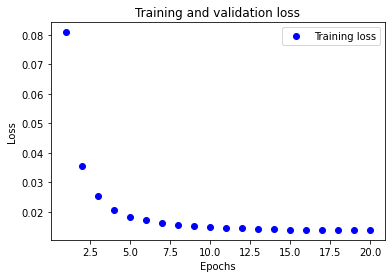

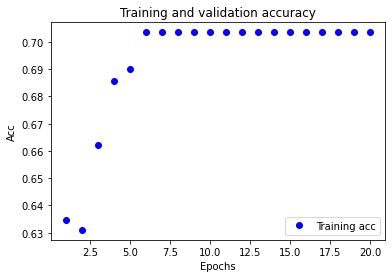

In [188]:
plt.plot(epochs,loss,'bo',label='Training loss')
plt.title('Training and validation loss')
plt.xlabel('Number of Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

plt.figure()
acc = history.history['accuracy']
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.title('Training and validation accuracy')
plt.xlabel('Number of Epochs')
plt.ylabel('Acc')
plt.legend()
plt.show()

In [189]:
predictions_cnnc3dhmp = cnn_model.predict(x_cnntest_c3d_hmp)
print(predictions_cnnc3dhmp.shape)
print(predictions_cnnc3dhmp)

(1200, 2)
[[0.860107   0.77901757]
 [0.8601047  0.7790154 ]
 [0.8601186  0.7790292 ]
 ...
 [0.86011183 0.77902246]
 [0.86011255 0.7790231 ]
 [0.86011565 0.77902627]]


In [190]:
Get_score(predictions_cnnc3dhmp, y_test)

The Spearman's correlation coefficient is: 0.263
The Spearman's correlation coefficient is: 0.161


### Implementing Stacking Model on combined C3D & HMP to predict scores for validation-set (20%) from dev-set:

> Algorithms used: Decision Tree, Support Vector Regression, and Bayesian Ridge.

In [53]:
# Preparing Data for Ensemble Stacking - Features Used C3D and HMP
x_c3d = np.array(final_pd['C3D'].tolist())
x_hmp = np.array(final_pd['HMP'].tolist())
X = np.concatenate((x_c3d,x_hmp),axis=1)

Y_ST=final_pd['short-term_memorability'].values
Y_LT=final_pd['long-term_memorability'].values

In [54]:
Xs_train, Xs_test, Ys_train, Ys_test = train_test_split(X, Y_ST, test_size=0.2, random_state=42)
Xl_train, Xl_test, Yl_train, Yl_test = train_test_split(X, Y_LT, test_size=0.2, random_state=42)
Xs_train.shape

(4800, 6176)

In [55]:
Xl_train = pd.DataFrame(Xl_train)
Xs_train = pd.DataFrame(Xs_train)
Xl_test = pd.DataFrame(Xl_test)
Xs_test = pd.DataFrame(Xs_test)
Yl_train =pd.DataFrame(Yl_train)
Ys_train = pd.DataFrame(Ys_train)
Ys_test = pd.DataFrame(Ys_test)
Yl_test = pd.DataFrame(Yl_test)

In [57]:
DT_st = DecisionTreeRegressor(random_state=42)

ST1_test ,ST1_train=Stacking(DT_st,Xs_train,Ys_train,Xs_test,5)
ST1_train=pd.DataFrame(ST1_train)
ST1_test=pd.DataFrame(ST1_test)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:293: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  warnings.warn(


In [58]:
DT_lt = DecisionTreeRegressor(random_state=42)
LT1_test ,LT1_train=Stacking(DT_lt,Xl_train,Yl_train,Xl_test,5)
LT1_train=pd.DataFrame(LT1_train)
LT1_test=pd.DataFrame(LT1_test)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:293: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  warnings.warn(


In [59]:
pred_st_model1 = DT_st.predict(Xs_test)
pred_lt_model1 = DT_lt.predict(Xl_test)

Get_score(pred_st_model1,Ys_test)
Get_score(pred_lt_model1,Yl_test)

The Spearman's correlation coefficient is: 0.124
The Spearman's correlation coefficient is: 0.049


In [60]:
SV_st = SVR(kernel='linear')
ST2_test ,ST2_train=Stacking(SV_st,Xs_train,Ys_train,Xs_test,5)
ST2_train=pd.DataFrame(ST2_train)
ST2_test=pd.DataFrame(ST2_test)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:293: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  warnings.warn(


In [61]:
SV_lt = SVR(kernel='linear')
LT2_test ,LT2_train=Stacking(SV_lt,Xl_train,Yl_train,Xl_test,5)
LT2_train=pd.DataFrame(LT2_train)
LT2_test=pd.DataFrame(LT2_test)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:293: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  warnings.warn(


In [62]:
pred_st_model2 = SV_st.predict(Xs_test)
pred_lt_model2 = SV_lt.predict(Xl_test)

Get_score(pred_st_model2,Ys_test)
Get_score(pred_lt_model2,Yl_test)

The Spearman's correlation coefficient is: 0.286
The Spearman's correlation coefficient is: 0.152


In [63]:
BR_st = BayesianRidge()
ST3_test ,ST3_train=Stacking(BR_st,Xs_train,Ys_train,Xs_test,5)
ST3_train=pd.DataFrame(ST3_train)
ST3_test=pd.DataFrame(ST3_test)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:293: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  warnings.warn(


In [64]:
BR_lt = BayesianRidge()
LT3_test ,LT3_train=Stacking(BR_lt,Xl_train,Yl_train,Xl_test,5)
LT3_train=pd.DataFrame(LT3_train)
LT3_test=pd.DataFrame(LT3_test)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:293: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  warnings.warn(


In [65]:
pred_st_model3 = BR_st.predict(Xs_test)
pred_lt_model3 = BR_lt.predict(Xl_test)

Get_score(pred_st_model3,Ys_test)
Get_score(pred_lt_model3,Yl_test)

The Spearman's correlation coefficient is: 0.289
The Spearman's correlation coefficient is: 0.176


In [66]:
c3d_hmp_st = pd.concat([ST1_train, ST2_train,ST3_train], axis=1)
c3d_hmp_st_test = pd.concat([ST1_test, ST2_test,ST3_test], axis=1)
c3d_hmp_model_st = LinearRegression()
c3d_hmp_model_st.fit(c3d_hmp_st,Ys_train)
pred_c3d_hmp_st = c3d_hmp_model_st.predict(c3d_hmp_st_test)

In [67]:
c3d_hmp_lt = pd.concat([LT1_train, LT2_train,LT3_train], axis=1)
c3d_hmp_lt_test = pd.concat([LT1_test, LT2_test,LT3_test], axis=1)
c3d_hmp_model_lt = LinearRegression()
c3d_hmp_model_lt.fit(c3d_hmp_lt,Yl_train)
pred_c3d_hmp_lt = c3d_hmp_model_lt.predict(c3d_hmp_lt_test)

In [68]:
Get_score(pred_c3d_hmp_st,Ys_test)
Get_score(pred_c3d_hmp_lt,Yl_test)

The Spearman's correlation coefficient is: 0.293
The Spearman's correlation coefficient is: 0.175


In [69]:
np.save(r'C:\Users\Administrator\Downloads\CA684 ML\scores\c3d_hmp_st_ensemble.npy', pred_c3d_hmp_st)
np.save(r'C:\Users\Administrator\Downloads\CA684 ML\scores\c3d_hmp_lt_ensemble.npy', pred_c3d_hmp_lt)

## Model Implementation and Evaluation with C3D, HMP, and Inception-V3 features combined together:

> C3D, HMP, and Inception-V3 values from combined dataframe are split into train and test set into 80:20 ratio.

> Spearman's correlation co-efficient is used for evaluating the predictions of validation-set (20%) from dev-set.

In [193]:
x_c3d = np.array(final_pd['C3D'].tolist())
x_hmp = np.array(final_pd['HMP'].tolist())
x_I0 = np.array(final_pd['I0'].tolist())
x_I56 = np.array(final_pd['I56'].tolist())
x_I112 = np.array(final_pd['I112'].tolist())

X = np.concatenate((x_c3d,x_hmp,x_I0,x_I56,x_I112),axis=1)
print(type(X))
print('x',X.shape)

y = final_pd[['short-term_memorability','long-term_memorability']].values

<class 'numpy.ndarray'>
x (6000, 9176)


In [194]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print('x_train', X_train.shape)
print('x_test', X_test.shape)
print('y_train', y_train.shape)
print('y_test', y_test.shape)

x_train (4800, 9176)
x_test (1200, 9176)
y_train (4800, 2)
y_test (1200, 2)


### Implementing Convolutional Neural Networks on combined C3D, HMP, and Inception-V3 to predict scores for validation-set (20%) from dev-set:

In [195]:
max_len = 9176

In [196]:
cnn_model = Sequential()

cnn_model.add(layers.Dense(10,activation='relu',kernel_regularizer=regularizers.l2(0.0005),input_shape=(max_len,)))
cnn_model.add(layers.Dropout(0.5))
cnn_model.add(layers.Dense(10,activation='relu',kernel_regularizer=regularizers.l2(0.0005)))
cnn_model.add(layers.Dropout(0.5))
cnn_model.add(layers.Dense(2,activation='sigmoid'))

In [197]:
cnn_model.compile(optimizer='rmsprop',loss='mse',metrics=['accuracy']) 

history = cnn_model.fit(X_train,y_train,epochs=30)

loss = history.history['loss']

epochs = range(1,len(loss)+1)

Epoch 1/30
150/150 [==============================] - 21s 15ms/step - loss: 0.0866 - accuracy: 0.5387
Epoch 2/30
150/150 [==============================] - 2s 15ms/step - loss: 0.0364 - accuracy: 0.5777
Epoch 3/30
150/150 [==============================] - 2s 11ms/step - loss: 0.0254 - accuracy: 0.6546
Epoch 4/30
150/150 [==============================] - 2s 12ms/step - loss: 0.0210 - accuracy: 0.6829
Epoch 5/30
150/150 [==============================] - 2s 14ms/step - loss: 0.0179 - accuracy: 0.6953
Epoch 6/30
150/150 [==============================] - 1s 9ms/step - loss: 0.0168 - accuracy: 0.7024
Epoch 7/30
150/150 [==============================] - 1s 9ms/step - loss: 0.0163 - accuracy: 0.7067
Epoch 8/30
150/150 [==============================] - 1s 9ms/step - loss: 0.0157 - accuracy: 0.6991
Epoch 9/30
150/150 [==============================] - 1s 8ms/step - loss: 0.0150 - accuracy: 0.7015: 
Epoch 10/30
150/150 [==============================] - 1s 8ms/step - loss: 0.0143 - accuracy

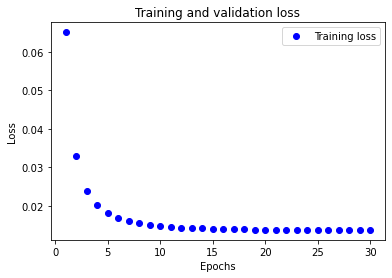

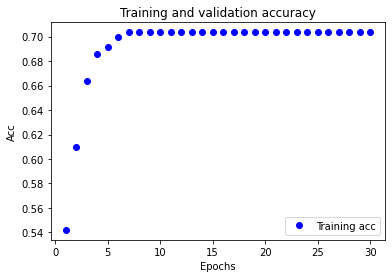

In [199]:
plt.plot(epochs,loss,'bo',label='Training loss')
plt.title('Training and validation loss')
plt.xlabel('Number of Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

plt.figure()
acc = history.history['accuracy']
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.title('Training and validation accuracy')
plt.xlabel('Number of Epochs')
plt.ylabel('Acc')
plt.legend()
plt.show()

In [201]:
predictions = cnn_model.predict(X_test)
print(predictions.shape)
Get_score(predictions, y_test)

(1200, 2)
The Spearman's correlation coefficient is: 0.192
The Spearman's correlation coefficient is: 0.137


### Implementing Stacking Model on combined C3D, HMP & Inception-V3 to predict scores for validation-set (20%) from dev-set:

> Algorithms used: Decision Tree, Support Vector Regression, and Bayesian Ridge.

In [75]:
x_c3d = np.array(final_pd['C3D'].tolist())
x_hmp = np.array(final_pd['HMP'].tolist())
x_I0 = np.array(final_pd['I0'].tolist())
x_I56 = np.array(final_pd['I56'].tolist())
x_I112 = np.array(final_pd['I112'].tolist())
X = np.concatenate((x_c3d,x_hmp,x_I0,x_I56,x_I112),axis=1)

Y_ST=final_pd['short-term_memorability'].values
Y_LT=final_pd['long-term_memorability'].values

In [76]:
Xs_train, Xs_test, Ys_train, Ys_test = train_test_split(X, Y_ST, test_size=0.2, random_state=42)
Xl_train, Xl_test, Yl_train, Yl_test = train_test_split(X, Y_LT, test_size=0.2, random_state=42)
Xs_train.shape

(4800, 9176)

In [77]:
Xl_train = pd.DataFrame(Xl_train)
Xs_train = pd.DataFrame(Xs_train)
Xl_test = pd.DataFrame(Xl_test)
Xs_test = pd.DataFrame(Xs_test)
Yl_train =pd.DataFrame(Yl_train)
Ys_train = pd.DataFrame(Ys_train)
Ys_test = pd.DataFrame(Ys_test)
Yl_test = pd.DataFrame(Yl_test)

In [79]:
DT_st = DecisionTreeRegressor(random_state=42)

ST1_test ,ST1_train=Stacking(DT_st,Xs_train,Ys_train,Xs_test,10)
ST1_train=pd.DataFrame(ST1_train)
ST1_test=pd.DataFrame(ST1_test)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:293: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  warnings.warn(


In [80]:
DT_lt = DecisionTreeRegressor(random_state=42)

LT1_test ,LT1_train=Stacking(DT_lt,Xl_train,Yl_train,Xl_test,10)
LT1_train=pd.DataFrame(LT1_train)
LT1_test=pd.DataFrame(LT1_test)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:293: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  warnings.warn(


In [81]:
pred_st_model1 = DT_st.predict(Xs_test)
pred_lt_model1 = DT_lt.predict(Xl_test)

Get_score(pred_st_model1,Ys_test)
Get_score(pred_lt_model1,Yl_test)

The Spearman's correlation coefficient is: 0.071
The Spearman's correlation coefficient is: 0.030


In [82]:
SV_st = SVR(kernel='linear')
ST2_test ,ST2_train=Stacking(SV_st,Xs_train,Ys_train,Xs_test,10)
ST2_train=pd.DataFrame(ST2_train)
ST2_test=pd.DataFrame(ST2_test)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:293: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  warnings.warn(


In [83]:
SV_lt = SVR(kernel='linear')
LT2_test ,LT2_train=Stacking(SV_lt,Xl_train,Yl_train,Xl_test,10)
LT2_train=pd.DataFrame(LT2_train)
LT2_test=pd.DataFrame(LT2_test)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:293: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  warnings.warn(


In [84]:
pred_st_model2 = SV_st.predict(Xs_test)
pred_lt_model2 = SV_lt.predict(Xl_test)

Get_score(pred_st_model2,Ys_test)
Get_score(pred_lt_model2,Yl_test)

The Spearman's correlation coefficient is: 0.246
The Spearman's correlation coefficient is: 0.178


In [85]:
BR_st = BayesianRidge()
ST3_test ,ST3_train=Stacking(BR_st,Xs_train,Ys_train,Xs_test,10)
ST3_train=pd.DataFrame(ST3_train)
ST3_test=pd.DataFrame(ST3_test)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:293: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  warnings.warn(


In [86]:
BR_lt = BayesianRidge()
LT3_test ,LT3_train=Stacking(BR_lt,Xl_train,Yl_train,Xl_test,10)
LT3_train=pd.DataFrame(LT3_train)
LT3_test=pd.DataFrame(LT3_test)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:293: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  warnings.warn(


In [87]:
pred_st_model3 = BR_st.predict(Xs_test)
pred_lt_model3 = BR_lt.predict(Xl_test)

Get_score(pred_st_model3,Ys_test)
Get_score(pred_lt_model3,Yl_test)

The Spearman's correlation coefficient is: 0.276
The Spearman's correlation coefficient is: 0.193


In [88]:
c3d_hmp_iv3_st = pd.concat([ST1_train, ST2_train,ST3_train], axis=1)
c3d_hmp_iv3_st_test = pd.concat([ST1_test, ST2_test,ST3_test], axis=1)
c3d_hmp_iv3_model_st = LinearRegression()
c3d_hmp_iv3_model_st.fit(c3d_hmp_iv3_st,Ys_train)
pred_c3d_hmp_iv3_st = c3d_hmp_iv3_model_st.predict(c3d_hmp_iv3_st_test)

In [89]:
c3d_hmp_iv3_lt = pd.concat([LT1_train, LT2_train,LT3_train], axis=1)
c3d_hmp_iv3_lt_test = pd.concat([LT1_test, LT2_test,LT3_test], axis=1)
c3d_hmp_iv3_model_lt = LinearRegression()
c3d_hmp_iv3_model_lt.fit(c3d_hmp_iv3_lt,Yl_train)
pred_c3d_hmp_iv3_lt = c3d_hmp_iv3_model_lt.predict(c3d_hmp_iv3_lt_test)

In [90]:
Get_score(pred_c3d_hmp_iv3_st,Ys_test)
Get_score(pred_c3d_hmp_iv3_lt,Yl_test)

The Spearman's correlation coefficient is: 0.274
The Spearman's correlation coefficient is: 0.188


In [91]:
np.save(r'C:\Users\Administrator\Downloads\CA684 ML\scores\c3d_hmp_iv3_st_ensemble.npy', pred_c3d_hmp_iv3_st)
np.save(r'C:\Users\Administrator\Downloads\CA684 ML\scores\c3d_hmp_iv3_lt_ensemble.npy', pred_c3d_hmp_iv3_lt)

### Implementing Weighted Average Ensemble for all the stacking models of each set of features selection to predict scores for validation-set (20%) from dev-set:

> Feature selection: Individual C3D, Weight: 0.60.

> Feature selection: Combined C3D & HMP, Weight: 0.25.

> Feature selection: Combined C3D, HMP & Inception-V3, Weight: 0.15.

In [94]:
C3D_LT = np.load(r'C:\Users\Administrator\Downloads\CA684 ML\scores\c3d_lt_ensemble.npy')
C3D_ST = np.load(r'C:\Users\Administrator\Downloads\CA684 ML\scores\c3d_st_ensemble.npy')

In [95]:
C3D_HMP_LT = np.load(r'C:\Users\Administrator\Downloads\CA684 ML\scores\c3d_hmp_lt_ensemble.npy')
C3D_HMP_ST = np.load(r'C:\Users\Administrator\Downloads\CA684 ML\scores\c3d_hmp_st_ensemble.npy')

In [96]:
C3D_HMP_Inception_LT = np.load(r'C:\Users\Administrator\Downloads\CA684 ML\scores\c3d_hmp_iv3_lt_ensemble.npy')
C3D_HMP_Inception_ST = np.load(r'C:\Users\Administrator\Downloads\CA684 ML\scores\c3d_hmp_iv3_st_ensemble.npy')

In [97]:
ST =(0.60 * C3D_ST) + (0.25 * C3D_HMP_ST) + (0.15 * C3D_HMP_Inception_ST)
LT =(0.60 * C3D_LT) + (0.25 * C3D_HMP_LT) + (0.15 * C3D_HMP_Inception_LT)

In [98]:
Get_score(ST,Ys_test)
Get_score(LT,Yl_test)

The Spearman's correlation coefficient is: 0.322
The Spearman's correlation coefficient is: 0.191


## Prediction of Video Memorability of videos in test-set using Weighted Average Ensemble Technique:

> Weighted Average Ensemble technique outperformed the CNN in predicting video memorability score when implemented on dev-set.

> Hence, the same technique is selected to predict memorability scores of videos in test-set.

### Loading videos and image features from test-set

#### Loading HMP values:

In [99]:
HMP_testset = r'C:\Users\Administrator\Downloads\CA684 ML\HMP_test'
df_hmp_testset=read_HMP(HMP_testset)

In [100]:
df_hmp_testset.shape
df_hmp_testset.head()

,video,HMP
0,video10000,"[0.127454, 0.020965, 0.000221, 0.0, 0.009964, ..."
1,video10001,"[0.015911, 0.003141, 0.000124, 0.0, 0.001083, ..."
2,video10002,"[0.041081, 0.013914, 0.000198, 0.0, 0.002648, ..."
3,video10003,"[0.047053, 0.009497, 0.000137, 0.0, 0.00867, 9..."
4,video10004,"[0.003161, 0.00033, 0.0, 0.0, 0.000189, 0.0, 0..."


#### Loading C3D values:

In [101]:
C3D_testset = r'C:\Users\Administrator\Downloads\CA684 ML\C3D_test'
df_c3d_testset=read_C3D(C3D_testset)

In [102]:
df_c3d_testset.head()

,video,C3D
0,video10000,"[0.01793277, 0.0177311, 0.0032704, 3.46e-06, 1..."
1,video10001,"[0.02396697, 0.00180796, 1.783e-05, 6e-08, 1e-..."
2,video10002,"[0.01869615, 0.86258429, 5e-07, 1.12e-06, 1.46..."
3,video10003,"[0.00055588, 0.00024811, 0.24000312, 3.271e-05..."
4,video10004,"[0.05058656, 0.00623968, 0.11702564, 0.0005364..."


#### Loading Inception-V3 values:

In [103]:
df_I0_test = pd.DataFrame()
df_I56_test = pd.DataFrame()
df_I112_test = pd.DataFrame()
vn0 = []
vn56 = []
vn112 = []
I0 = []
I56 = []
I112 = []

IV3_testset = r'C:\Users\Administrator\Downloads\CA684 ML\Inception_test'
for filename in os.listdir(IV3_testset):
    if filename.endswith("-0.txt"):
        f=filename.replace('-0.txt','')
        ff = os.path.join(IV3_testset, filename)
        vn0.append(f)
        I0.append(read_InceptionV3(ff))
    if filename.endswith("-56.txt"):
        f=filename.replace('-56.txt','')
        ff = os.path.join(IV3_testset, filename)
        vn56.append(f)
        I56.append(read_InceptionV3(ff))
    if filename.endswith("-112.txt"):
        f=filename.replace('-112.txt','')
        ff = os.path.join(IV3_testset, filename)
        vn112.append(f)
        I112.append(read_InceptionV3(ff))
        
df_I0_test['video'] = vn0
df_I0_test['I0'] = I0
df_I56_test['video'] = vn56
df_I56_test['I56'] = I56
df_I112_test['video'] = vn112
df_I112_test['I112'] = I112

In [104]:
df_iv3_testset = df_I0_test.merge(df_I56_test,on='video').merge(df_I112_test,on='video')

In [105]:
df_iv3_testset.head()

,video,I0,I56,I112
0,video10000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1,video10001,"[0.0, 0.0, 0.0, 0.0, 3.441508e-35, 0.0, 0.0, 1...","[0.0, 0.0, 0.0, 0.0, 7.105653e-32, 0.0, 0.0, 1...","[3.783192e-32, 4.17513e-36, 5.121327e-31, 0.0,..."
2,video10002,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
3,video10003,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
4,video10004,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


#### Combining C3D, HMP, and Inception-V3 values from test-set into single dataframe:

In [106]:
testset_pd = df_c3d_testset.merge(df_hmp_testset, on='video', how='inner').merge(df_iv3_testset,on='video',how='inner')

testset_pd.head()

,video,C3D,HMP,I0,I56,I112
0,video10000,"[0.01793277, 0.0177311, 0.0032704, 3.46e-06, 1...","[0.127454, 0.020965, 0.000221, 0.0, 0.009964, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1,video10001,"[0.02396697, 0.00180796, 1.783e-05, 6e-08, 1e-...","[0.015911, 0.003141, 0.000124, 0.0, 0.001083, ...","[0.0, 0.0, 0.0, 0.0, 3.441508e-35, 0.0, 0.0, 1...","[0.0, 0.0, 0.0, 0.0, 7.105653e-32, 0.0, 0.0, 1...","[3.783192e-32, 4.17513e-36, 5.121327e-31, 0.0,..."
2,video10002,"[0.01869615, 0.86258429, 5e-07, 1.12e-06, 1.46...","[0.041081, 0.013914, 0.000198, 0.0, 0.002648, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
3,video10003,"[0.00055588, 0.00024811, 0.24000312, 3.271e-05...","[0.047053, 0.009497, 0.000137, 0.0, 0.00867, 9...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
4,video10004,"[0.05058656, 0.00623968, 0.11702564, 0.0005364...","[0.003161, 0.00033, 0.0, 0.0, 0.000189, 0.0, 0...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


### Performing test-set predictions for each set of features selection:

#### Test-set predictions using C3D:

In [107]:
X = np.array(final_pd['C3D'].tolist())
X = pd.DataFrame(X)

Y_ST=final_pd['short-term_memorability'].values
Y_LT=final_pd['long-term_memorability'].values

In [108]:
Y_ST = pd.DataFrame(Y_ST)
Y_LT = pd.DataFrame(Y_LT)

In [109]:
X_test = np.array(testset_pd['C3D'].tolist())
X_test = pd.DataFrame(X_test)

In [110]:
DT_st = DecisionTreeRegressor(random_state=42)
ST1_test ,ST1_train=Stacking(DT_st,X,Y_ST,X_test,10)
ST1_train=pd.DataFrame(ST1_train)
ST1_test=pd.DataFrame(ST1_test)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:293: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  warnings.warn(


In [111]:
DT_lt = DecisionTreeRegressor(random_state=42)
LT1_test ,LT1_train=Stacking(DT_lt,X,Y_LT,X_test,10)
LT1_train=pd.DataFrame(LT1_train)
LT1_test=pd.DataFrame(LT1_test)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:293: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  warnings.warn(


In [112]:
pred_st_model1 = DT_st.predict(X_test)
pred_lt_model1 = DT_lt.predict(X_test)

In [113]:
RF_st = RandomForestRegressor()
ST2_test ,ST2_train=Stacking(RF_st,X,Y_ST,X_test,10)
ST2_train=pd.DataFrame(ST2_train)
ST2_test=pd.DataFrame(ST2_test)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:293: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  warnings.warn(


In [114]:
RF_lt = RandomForestRegressor()
LT2_test ,LT2_train=Stacking(RF_lt,X,Y_LT,X_test,10)
LT2_train=pd.DataFrame(LT2_train)
LT2_test=pd.DataFrame(LT2_test)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:293: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  warnings.warn(


In [115]:
pred_st_model2 = RF_st.predict(X_test)
pred_lt_model2 = RF_lt.predict(X_test)

In [116]:
BR_st = BayesianRidge()
ST3_test ,ST3_train=Stacking(BR_st,X,Y_ST,X_test,10)
ST3_train=pd.DataFrame(ST3_train)
ST3_test=pd.DataFrame(ST3_test)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:293: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  warnings.warn(


In [117]:
BR_lt = BayesianRidge()
LT3_test ,LT3_train=Stacking(BR_lt,X,Y_LT,X_test,10)
LT3_train=pd.DataFrame(LT3_train)
LT3_test=pd.DataFrame(LT3_test)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:293: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  warnings.warn(


In [118]:
pred_st_model3 = BR_st.predict(X_test)
pred_lt_model3 = BR_lt.predict(X_test)

In [119]:
c3d_st = pd.concat([ST1_train, ST2_train,ST3_train], axis=1)
c3d_st_test = pd.concat([ST1_test, ST2_test,ST3_test], axis=1)
c3d_model_st = LinearRegression()
c3d_model_st.fit(c3d_st,Y_ST)
c3d_st = c3d_model_st.predict(c3d_st_test)

In [120]:
c3d_lt = pd.concat([LT1_train, LT2_train,LT3_train], axis=1)
c3d_lt_test = pd.concat([LT1_test, LT2_test,LT3_test], axis=1)
c3d_model_lt = LinearRegression()
c3d_model_lt.fit(c3d_lt,Y_LT)
c3d_lt = c3d_model_lt.predict(c3d_lt_test)

In [153]:
np.save(r'C:\Users\Administrator\Downloads\CA684 ML\scores\C3D_FinalPredictions_ST.npy', c3d_st)
np.save(r'C:\Users\Administrator\Downloads\CA684 ML\scores\C3D_FinalPredictions_LT.npy', c3d_lt)

#### Test-set predictions using combined C3D & HMP:

In [122]:
x_c3d = np.array(final_pd['C3D'].tolist())
x_hmp = np.array(final_pd['HMP'].tolist())
X = np.concatenate((x_c3d,x_hmp),axis=1)
X = pd.DataFrame(X)

Y_ST=final_pd['short-term_memorability'].values
Y_LT=final_pd['long-term_memorability'].values

In [123]:
Y_ST = pd.DataFrame(Y_ST)
Y_LT = pd.DataFrame(Y_LT)

In [124]:
x_c3d_test = np.array(testset_pd['C3D'].tolist())
x_hmp_test = np.array(testset_pd['HMP'].tolist())
X_test = np.concatenate((x_c3d_test,x_hmp_test),axis=1)
X_test = pd.DataFrame(X_test)

In [125]:
DT_st = DecisionTreeRegressor(random_state=42)
ST1_test ,ST1_train=Stacking(DT_st,X,Y_ST,X_test,10)
ST1_train=pd.DataFrame(ST1_train)
ST1_test=pd.DataFrame(ST1_test)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:293: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  warnings.warn(


In [126]:
DT_lt = DecisionTreeRegressor(random_state=42)
LT1_test ,LT1_train=Stacking(DT_lt,X,Y_LT,X_test,10)
LT1_train=pd.DataFrame(LT1_train)
LT1_test=pd.DataFrame(LT1_test)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:293: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  warnings.warn(


In [127]:
pred_st_model1 = DT_st.predict(X_test)
pred_lt_model1 = DT_lt.predict(X_test)

In [128]:
SV_st = SVR(kernel='linear')
ST2_test ,ST2_train=Stacking(SV_st,X,Y_ST,X_test,10)
ST2_train=pd.DataFrame(ST2_train)
ST2_test=pd.DataFrame(ST2_test)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:293: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  warnings.warn(


In [129]:
SV_lt = SVR(kernel='linear')
LT2_test ,LT2_train=Stacking(SV_lt,X,Y_LT,X_test,10)
LT2_train=pd.DataFrame(LT2_train)
LT2_test=pd.DataFrame(LT2_test)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:293: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  warnings.warn(


In [130]:
pred_st_model2 = SV_st.predict(X_test)
pred_lt_model2 = SV_lt.predict(X_test)

In [131]:
BR_st = BayesianRidge()
ST3_test ,ST3_train=Stacking(BR_st,X,Y_ST,X_test,10)
ST3_train=pd.DataFrame(ST3_train)
ST3_test=pd.DataFrame(ST3_test)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:293: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  warnings.warn(


In [132]:
BR_lt = BayesianRidge()
LT3_test ,LT3_train=Stacking(BR_lt,X,Y_LT,X_test,10)
LT3_train=pd.DataFrame(LT3_train)
LT3_test=pd.DataFrame(LT3_test)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:293: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  warnings.warn(


In [133]:
pred_st_model3 = BR_st.predict(X_test)
pred_lt_model3 = BR_lt.predict(X_test)

In [134]:
c3d_hmp_st = pd.concat([ST1_train, ST2_train,ST3_train], axis=1)
c3d_hmp_st_test = pd.concat([ST1_test, ST2_test,ST3_test], axis=1)
c3d_hmp_model_st = LinearRegression()
c3d_hmp_model_st.fit(c3d_hmp_st,Y_ST)
c3d_hmp_st = c3d_hmp_model_st.predict(c3d_hmp_st_test)

In [135]:
c3d_hmp_lt = pd.concat([LT1_train, LT2_train,LT3_train], axis=1)
c3d_hmp_lt_test = pd.concat([LT1_test, LT2_test,LT3_test], axis=1)
c3d_hmp_model_lt = LinearRegression()
c3d_hmp_model_lt.fit(c3d_hmp_lt,Y_LT)
c3d_hmp_lt = c3d_hmp_model_lt.predict(c3d_hmp_lt_test)

In [136]:
np.save(r'C:\Users\Administrator\Downloads\CA684 ML\scores\C3D_HMP_Final_Predictions_ST.npy', c3d_hmp_st)
np.save(r'C:\Users\Administrator\Downloads\CA684 ML\scores\C3D_HMP_Final_Predictions_LT.npy', c3d_hmp_lt)

#### Test-set predictions using combined C3D, HMP, and Inception-V3:

In [137]:
x_c3d = np.array(final_pd['C3D'].tolist())
x_hmp = np.array(final_pd['HMP'].tolist())
x_I0 = np.array(final_pd['I0'].tolist())
x_I56 = np.array(final_pd['I56'].tolist())
x_I112 = np.array(final_pd['I112'].tolist())
X = np.concatenate((x_c3d,x_hmp,x_I0,x_I56,x_I112),axis=1)
X=pd.DataFrame(X)

In [138]:
Y_ST = pd.DataFrame(Y_ST)
Y_LT = pd.DataFrame(Y_LT)

In [139]:
x_c3d_test = np.array(testset_pd['C3D'].tolist())
x_hmp_test = np.array(testset_pd['HMP'].tolist())
x_I0_test = np.array(testset_pd['I0'].tolist())
x_I56_test = np.array(testset_pd['I56'].tolist())
x_I112_test = np.array(testset_pd['I112'].tolist())
X_test = np.concatenate((x_c3d_test,x_hmp_test, x_I0_test, x_I56_test, x_I112_test),axis=1)
X_test = pd.DataFrame(X_test)

In [140]:
DT_st = DecisionTreeRegressor(random_state=42)
ST1_test ,ST1_train=Stacking(DT_st,X,Y_ST,X_test,10)
ST1_train=pd.DataFrame(ST1_train)
ST1_test=pd.DataFrame(ST1_test)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:293: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  warnings.warn(


In [141]:
DT_lt = DecisionTreeRegressor(random_state=42)
LT1_test ,LT1_train=Stacking(DT_lt,X,Y_LT,X_test,10)
LT1_train=pd.DataFrame(LT1_train)
LT1_test=pd.DataFrame(LT1_test)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:293: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  warnings.warn(


In [142]:
pred_st_model1 = DT_st.predict(X_test)
pred_lt_model1 = DT_lt.predict(X_test)

In [143]:
SV_st = SVR(kernel='linear')
ST2_test ,ST2_train=Stacking(SV_st,X,Y_ST,X_test,10)
ST2_train=pd.DataFrame(ST2_train)
ST2_test=pd.DataFrame(ST2_test)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:293: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  warnings.warn(


In [144]:
SV_lt = SVR(kernel='linear')
LT2_test ,LT2_train=Stacking(model2_lt,X,Y_LT,X_test,10)
LT2_train=pd.DataFrame(LT2_train)
LT2_test=pd.DataFrame(LT2_test)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:293: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  warnings.warn(


In [145]:
pred_st_model2 = SV_st.predict(X_test)
pred_lt_model2 = SV_lt.predict(X_test)

In [146]:
BR_st = BayesianRidge()
ST3_test ,ST3_train=Stacking(BR_st,X,Y_ST,X_test,10)
ST3_train=pd.DataFrame(ST3_train)
ST3_test=pd.DataFrame(ST3_test)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:293: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  warnings.warn(


In [147]:
BR_lt = BayesianRidge()
LT3_test ,LT3_train=Stacking(BR_lt,X,Y_LT,X_test,10)
LT3_train=pd.DataFrame(LT3_train)
LT3_test=pd.DataFrame(LT3_test)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:293: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  warnings.warn(


In [148]:
pred_st_model3 = BR_st.predict(X_test)
pred_lt_model3 = BR_lt.predict(X_test)

In [149]:
c3d_hmp_iv3_st = pd.concat([ST1_train, ST2_train,ST3_train], axis=1)
c3d_hmp_iv3_st_test = pd.concat([ST1_test, ST2_test,ST3_test], axis=1)
c3d_hmp_iv3_model_st = LinearRegression()
c3d_hmp_iv3_model_st.fit(c3d_hmp_iv3_st,Y_ST)
c3d_hmp_iv3_st = c3d_hmp_iv3_model_st.predict(c3d_hmp_iv3_st_test)

In [150]:
c3d_hmp_iv3_lt = pd.concat([LT1_train, LT2_train,LT3_train], axis=1)
c3d_hmp_iv3_lt_test = pd.concat([LT1_test, LT2_test,LT3_test], axis=1)
c3d_hmp_iv3_model_lt = LinearRegression()
c3d_hmp_iv3_model_lt.fit(c3d_hmp_iv3_lt,Y_LT)
c3d_hmp_iv3_lt = c3d_hmp_iv3_model_lt.predict(c3d_hmp_iv3_lt_test)

In [151]:
np.save(r'C:\Users\Administrator\Downloads\CA684 ML\scores\C3D_HMP_IV3_Final_Predictions_ST.npy', c3d_hmp_iv3_st)
np.save(r'C:\Users\Administrator\Downloads\CA684 ML\scores\C3D_HMP_IV3_Final_Predictions_LT.npy', c3d_hmp_iv3_lt)

#### Implementing Weighted Average Ensemble for all the stacking models of each set of features selection to predict scores for test-set:

> Feature selection: Individual C3D, Weight: 0.60.

> Feature selection: Combined C3D & HMP, Weight: 0.25.

> Feature selection: Combined C3D, HMP & Inception-V3, Weight: 0.15.

In [154]:
C3D_LT = np.load(r'C:\Users\Administrator\Downloads\CA684 ML\scores\C3D_FinalPredictions_LT.npy')
C3D_ST = np.load(r'C:\Users\Administrator\Downloads\CA684 ML\scores\C3D_FinalPredictions_ST.npy')

In [155]:
C3D_HMP_LT = np.load(r'C:\Users\Administrator\Downloads\CA684 ML\scores\C3D_HMP_Final_Predictions_LT.npy')
C3D_HMP_ST = np.load(r'C:\Users\Administrator\Downloads\CA684 ML\scores\C3D_HMP_Final_Predictions_ST.npy')

In [156]:
C3D_HMP_IV3_LT = np.load(r'C:\Users\Administrator\Downloads\CA684 ML\scores\C3D_HMP_IV3_Final_Predictions_LT.npy')
C3D_HMP_IV3_ST = np.load(r'C:\Users\Administrator\Downloads\CA684 ML\scores\C3D_HMP_IV3_Final_Predictions_ST.npy')

In [157]:
# Assigning Weights for all Stacking Predictions

Pred_LT =(0.50 * C3D_LT) + (0.35 * C3D_HMP_LT) + (0.15 * C3D_HMP_IV3_LT)

In [ ]:
Pred_ST =(0.60 * C3D_ST) + (0.25 * C3D_HMP_ST) + (0.15 * C3D_HMP_IV3_ST)

In [159]:
ground_truth_template = pd.read_csv(r'C:\Users\Administrator\Downloads\CA684 ML\Ground-truth_test\ground_truth_template.csv')

In [160]:
ST_score_df= pd.DataFrame(Pred_ST)
ground_truth_template['short-term_memorability']=ST_score_df
LT_score_df= pd.DataFrame(Pred_LT)
ground_truth_template['long-term_memorability']=LT_score_df

In [202]:
ground_truth_template.to_csv(r'C:\Users\Administrator\Downloads\CA684 ML\Ground-truth_test\Vinay_Jagdish_Jethmalani_20210984_predictions.csv',index=False)


In [203]:
ground_truth_template.head()

,video,short-term_memorability,nb_short-term_annotations,long-term_memorability,nb_long-term_annotations
0,7494,0.870901,33,0.794929,12
1,7495,0.879287,34,0.799437,10
2,7496,0.902808,32,0.803145,13
3,7497,0.853479,33,0.773363,10
4,7498,0.873501,33,0.780342,10
